# DEMO: Explaining Groups of Points in Low Dimensional Representations

In this notebook we will go through some toy examples of the approach proposed in [this](https://proceedings.icml.cc/book/2020/hash/ccbd8ca962b80445df1f7f38c57759f0) paper to explain clusters in low dim representations of high dim data.

In [1]:
# imports
import os
import csv
import json
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd

os.system("rm *.png")

import sys
sys.path.insert(0, "../Code/")
from explain_cs import explain
from load_scvis import load_vae
from misc import poly2labels, load
from metrics import metrics, eval_epsilon, similarity
from myplot import plot_polys, plot_groups, plot_metrics, plot_explanation

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Boston Housing Data

In [2]:
# Load Data

# minmax scaled boston housing data
x = pd.read_csv("../Housing/Data/X.tsv", sep="\t").values
y = pd.read_csv("../Housing/Data/y.tsv", sep="\t").values

In [3]:
# Load VAE and Clustering Model results from previously run clustering

# cluster definitions
with open("../Housing/vertices.json") as json_file:  
    all_vertices = json.load(json_file)

# metadata
input_dim = x.shape[1]
num_clusters = len(all_vertices)

# path to pretrained vae and func to load it
model_file = "/home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt"
def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file)

In [4]:
# Calculate Data Representation (low dimensional)

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


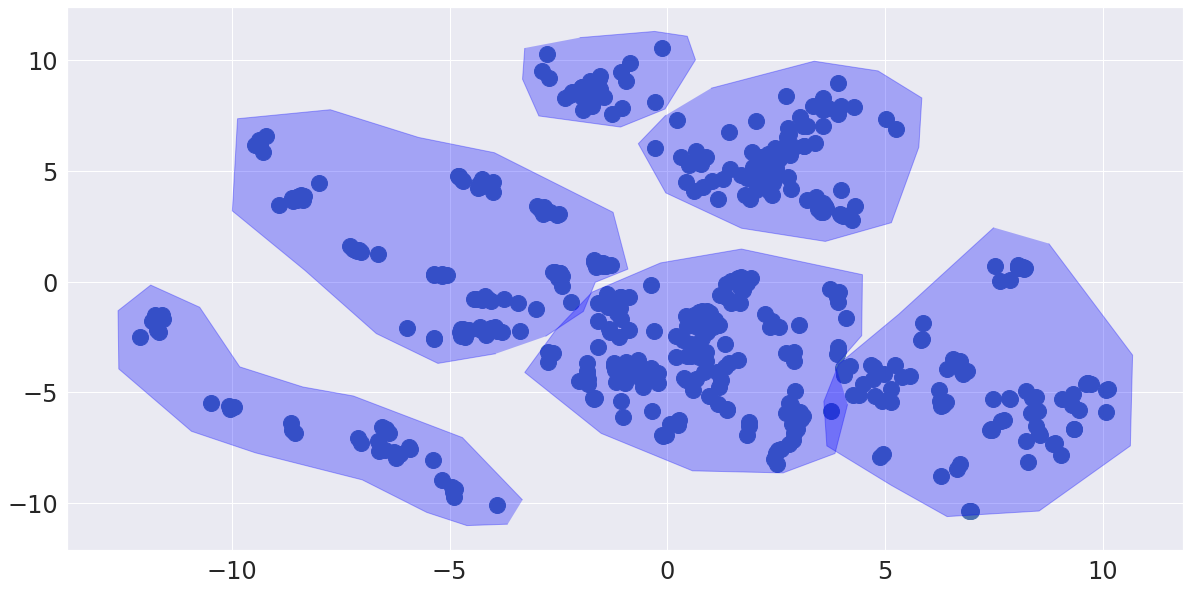

In [5]:
# Visualize the data and the marked clusters

plot_polys(data_rep, all_vertices)

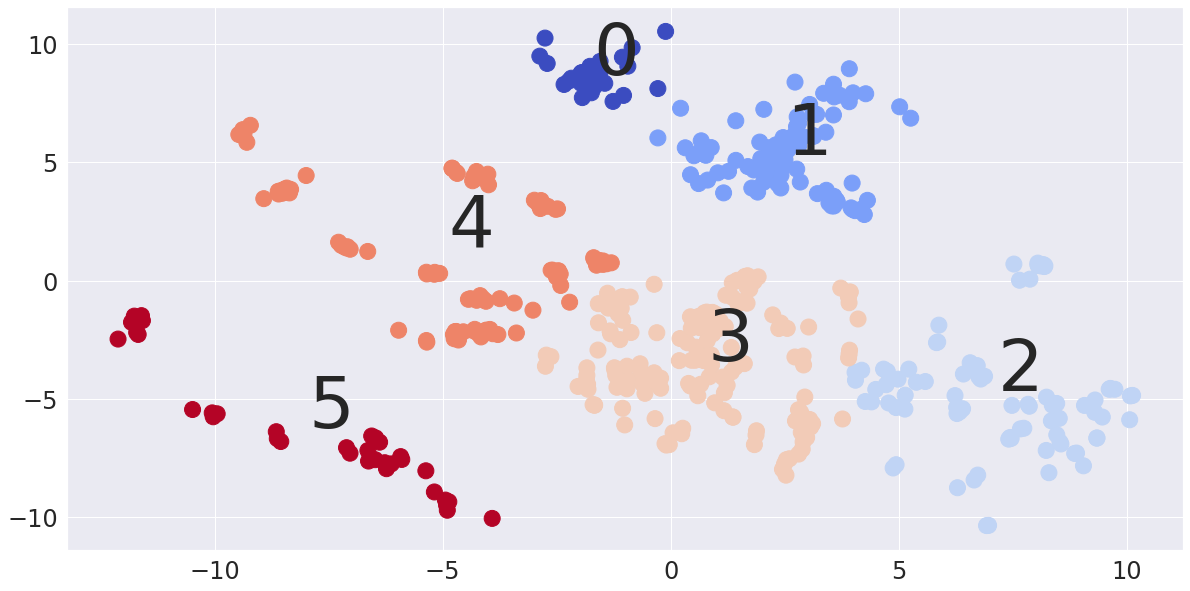

In [6]:
# Visualize the clusters in the learned representation

labels = poly2labels(data_rep, all_vertices)
means, centers, indices = plot_groups(x, data_rep, num_clusters, labels, name = "housing-rep.png")

In [9]:
# Set epsilon for our metrics

# if an "initial + delta" point is within epsilon distance of
# a point in target region, then consider successful mapping
epsilon = 1.5

if True:
    os.system("rm epsilon.txt")
    eval_epsilon(load_model, x, indices, epsilon)


INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


In [12]:
# Init sparsity experiment results matrix
run = True

# Initialize results 
# Columns are:  K, TGT-correctness, TGT-coverage, DBM-correctness, DBM-coverage
# K = [1, 3, 5, 7, 9, 11, 13]
K = [11, 13]
if run:
    os.system("rm *.npy")
    os.system("rm out.csv")
    
    out = np.zeros((len(K), 5))

    c = 0
    for k in K:
        out[c, 0] = k
        c += 1

In [13]:
# Evaluate DBM 

if run:
    exp_mean = np.zeros((num_clusters - 1, input_dim))
    for i in range(num_clusters - 1):
        exp_mean[i, :] = means[i + 1] - means[0]

    c = 0
    for k in K:
        a, b = metrics(load_model, x, indices, exp_mean, epsilon, k = k)

        out[c, 3] = np.mean(a)
        out[c, 4] = np.mean(b)

        c += 1

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


In [14]:
# Evaluate the group explanations (ELDR) at each of a range of sparsities

if run:

    c = 0
    for k in tqdm(K):

        best_val = 0.0
        for lg in tqdm([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]):
            for trial in range(5):

                deltas = explain(load_model, means, centers, learning_rate = 0.01, consecutive_steps = 5, lambda_global = lg)
                a, b = metrics(load_model, x, indices, deltas, epsilon, k = k) 

                val = np.mean(a)

                if val > best_val:
                    best_val = val
                    out[c, 1] = best_val
                    out[c, 2] = np.mean(b)
                    np.save("deltas" + str(k) + ".npy", deltas)

                os.system("rm -rf explanation")

        c += 1

  0%|          | 0/11 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt



INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rat


  9%|▉         | 1/11 [00:36<06:09, 36.95s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 18%|█▊        | 2/11 [01:20<05:51, 39.01s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 27%|██▋       | 3/11 [02:07<05:29, 41.22s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 36%|███▋      | 4/11 [02:54<05:02, 43.19s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 45%|████▌     | 5/11 [03:32<04:09, 41.52s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 55%|█████▍    | 6/11 [04:10<03:22, 40.55s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 64%|██████▎   | 7/11 [04:48<02:39, 39.77s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 73%|███████▎  | 8/11 [05:28<01:59, 39.87s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 82%|████████▏ | 9/11 [06:01<01:15, 37.76s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 91%|█████████ | 10/11 [06:32<00:35, 35.71s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


  9%|▉         | 1/11 [00:49<08:16, 49.61s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 18%|█▊        | 2/11 [01:25<06:50, 45.56s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 27%|██▋       | 3/11 [01:58<05:34, 41.83s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 36%|███▋      | 4/11 [02:44<05:01, 43.07s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 45%|████▌     | 5/11 [03:21<04:07, 41.21s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 55%|█████▍    | 6/11 [04:02<03:24, 40.97s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 64%|██████▎   | 7/11 [04:40<02:40, 40.07s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 73%|███████▎  | 8/11 [05:14<01:54, 38.29s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 82%|████████▏ | 9/11 [05:48<01:14, 37.18s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


 91%|█████████ | 10/11 [06:20<00:35, 35.62s/it]

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0


100%|██████████| 2/2 [13:47<00:00, 413.53s/it]


In [15]:
# Save results
if run:
    np.savetxt("out.csv", out, delimiter = ",")
else:
    out = np.loadtxt("out.csv", delimiter = ",")
    
print(out)

[[11.          0.92230378  0.77794989  0.88108726  0.80676594]
 [13.          0.92995609  0.78080884  0.88155791  0.80659014]]


### experimental begin

In [75]:
Xdf = pd.DataFrame(data=bunch.data, columns=bunch.feature_names).head()
Xdf.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000
mean,0.032468,3.600000,4.162000,0.0,0.478400,6.865200,61.040000,5.229720,2.20000,244.800000,17.660000,395.632000,5.284000
std,0.022778,8.049845,2.655159,0.0,0.033768,0.346716,12.402943,0.840081,0.83666,30.318311,1.393915,1.849235,2.346813
min,0.006320,0.000000,2.180000,0.0,0.458000,6.421000,45.800000,4.090000,1.00000,222.000000,15.300000,392.830000,2.940000
25%,0.027290,0.000000,2.180000,0.0,0.458000,6.575000,54.200000,4.967100,2.00000,222.000000,17.800000,394.630000,4.030000
50%,0.027310,0.000000,2.310000,0.0,0.469000,6.998000,61.100000,4.967100,2.00000,242.000000,17.800000,396.900000,4.980000
75%,0.032370,0.000000,7.070000,0.0,0.469000,7.147000,65.200000,6.062200,3.00000,242.000000,18.700000,396.900000,5.330000
max,0.069050,18.000000,7.070000,0.0,0.538000,7.185000,78.900000,6.062200,3.00000,296.000000,18.700000,396.900000,9.140000


In [39]:
from sklearn.datasets import load_boston
bunch = load_boston()
bunch.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [69]:
print(bunch.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

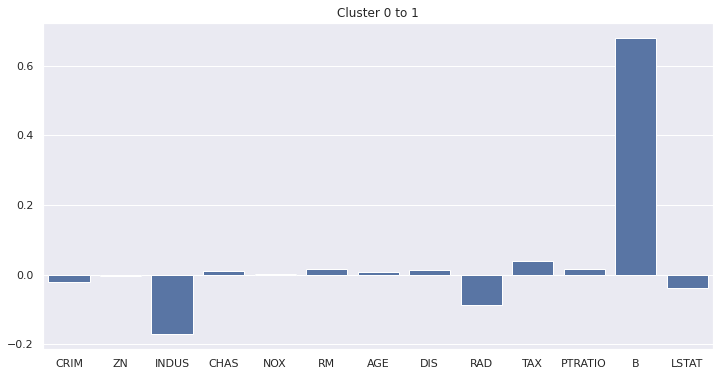

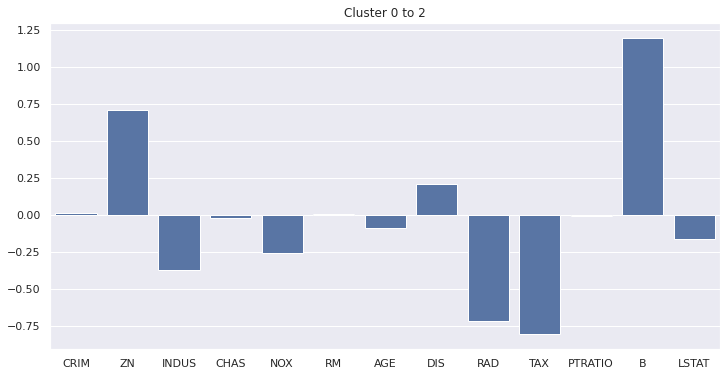

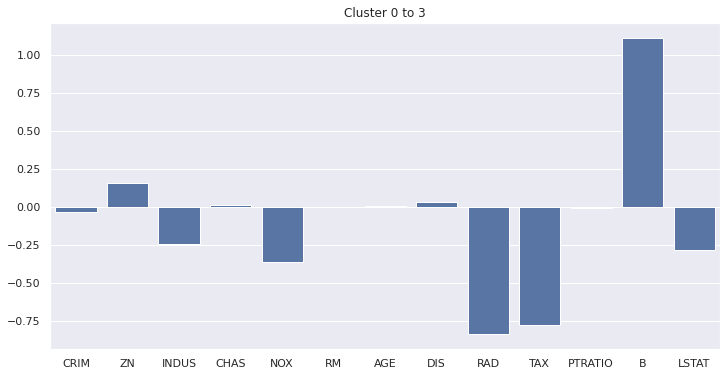

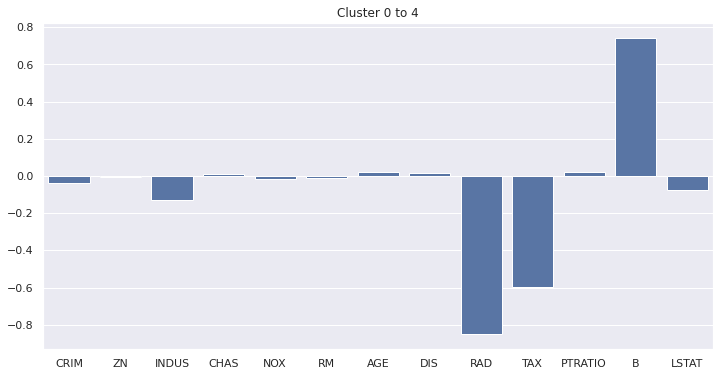

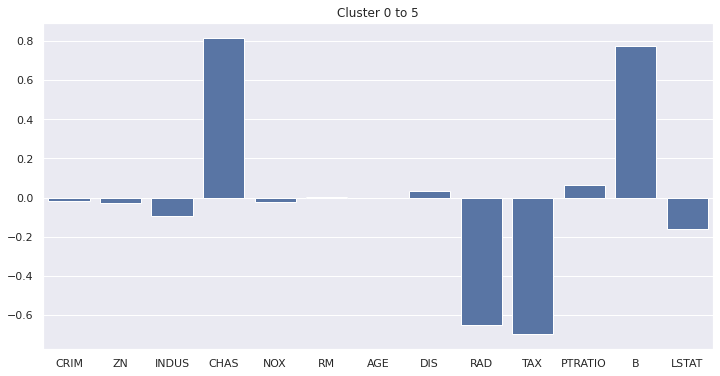

In [64]:
xdf = pd.read_csv("../Housing/Data/X.tsv", sep="\t")

for i in range(len(deltas)):
    fig, ax = plt.subplots(figsize=(12,6 ))
    sns.barplot(x=bunch.feature_names, y=deltas[i], ax=ax, color='b')
    plt.title(f'Cluster 0 to {i+1}')
    plt.show()

In [30]:
# take data points from group 0 and add delta 1 to make them into region 1

sess, rep, X, D = load_model()

INITIAL_GROUP = 5
TARGET_GROUP = 4

if INITIAL_GROUP == 0:
    d = deltas[TARGET_GROUP - 1]
elif TARGET_GROUP == 0:
    d = -1.0 * deltas[INITIAL_GROUP - 1]
else:
    d = -1.0 * deltas[INITIAL_GROUP - 1] + deltas[TARGET_GROUP - 1]

# take points from initial group and apply delta
x_init_transf = x[labels==INITIAL_GROUP] + d

# get low dim repr of initial + delta (i.e. transformed initial pts)
x_init_transf_lowdim = sess.run(rep, feed_dict={X: x_init_transf, D: np.zeros((1, input_dim))})

# what group did the clustering algo classify these to
x_init_transf_lowdim_labels = poly2labels(x_init_transf_lowdim, all_vertices)
x_init_transf_lowdim_labels

INFO:tensorflow:Restoring parameters from /home/kachau/Documents/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 3., 3., 3., 3., 3., 2., 4., 4., 4., 4., 4., 4., 4.,
       4.])